<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Stan/notebooks/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [1]:
!pip install nussl

     |████████████████████████████████| 239 kB 5.0 MB/s 
     |████████████████████████████████| 251 kB 52.5 MB/s 
     |████████████████████████████████| 146 kB 48.1 MB/s 
     |████████████████████████████████| 310 kB 56.5 MB/s 
     |████████████████████████████████| 51 kB 62 kB/s 
     |████████████████████████████████| 3.3 MB 37.8 MB/s 
     |████████████████████████████████| 87 kB 7.1 MB/s 
     |████████████████████████████████| 963 kB 51.4 MB/s 
     |████████████████████████████████| 130 kB 59.8 MB/s 
     |████████████████████████████████| 6.2 MB 19.5 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=bec0cc56c3ca994be0dde22dd275f8e737bb2f1337c171c93ded5d5a95633855
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=46710339ec87c80aabf71bd9aedbbb9d78bb67a599c194dedcd1bc99219e1665
  Stored in d

In [2]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

  Cloning https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator to /tmp/pip-req-build-fp4yd123
  Running command git clone -q https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator /tmp/pip-req-build-fp4yd123
  Created wheel for voice-separator: filename=voice_separator-0.0.1-py3-none-any.whl size=5584 sha256=7b1e9fcbe25e7d79f4a859730f187d8be95ca8981420e1eaf027c970b3256eff
  Stored in directory: /tmp/pip-ephem-wheel-cache-j023vkzu/wheels/89/ad/91/9cded351057b1a842fbbfa97f091da426d85036b0efd2e0273
Successfully built voice-separator


In [3]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np
import concurrent.futures
import time

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# Montage du drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Récupération des données

In [5]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

Ces variables sont des hooks dataset, et pas directement l'entièreté des données (pour ne pas exploser la RAM). Il est possible d'accéder aux items du dataset par le getitem python classique : `musdb[i]`.

Exemple :

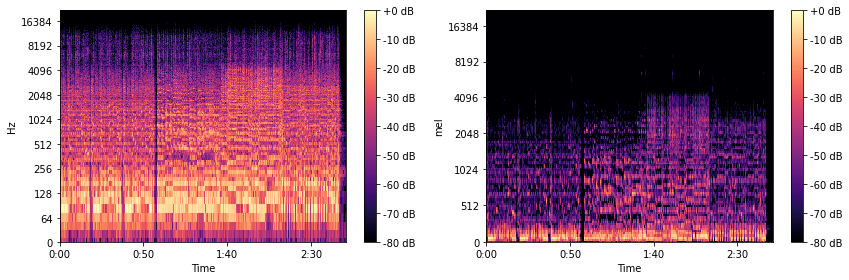

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f452b87e5f0> (for post_execute):


KeyboardInterrupt: ignored

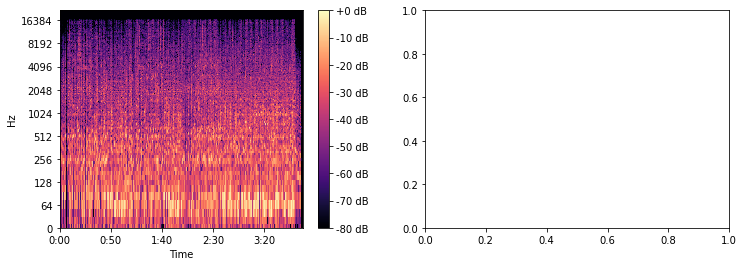

In [25]:
for i in range(3):
  plt.figure(figsize=(12,4))

  plt.subplot(121)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis='log')
  plt.colorbar(format='%+2.0f dB')

  plt.subplot(122)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis="mel")
  plt.colorbar(format='%+2.0f dB')
  plt.ylabel("mel")
  plt.tight_layout()
  plt.show()

# Paramètres du modèle

In [41]:
#  Préprocess
freq                  = 4096      # fréquence de reéchantillonage
window_length         = 511       # taille fenêtre FFT
hop_length            = 384       # recouvrement FFT
patch_size            =  64       # taille du patch temporel pour  CNN   
augmentation_factor   = 2         # paramètres de data augmentation

nfreq                 = 256       # nombre de bins dans l'espace fréquentiel   = (window_length)/2        


#  CNN
batch_size      = 2        # taille des batch (en nombre de chansons)
val_batch_size  = 2        # taille des batch pour la validation (en nombre de chansons)
val_ratio       = 0.1      # fraction des data pour validation


# Définition de fonctions utiles

Une fonction pour le préprocessing des données :
- rééchantillonage,
- passage en mono,
- STFT et séparation magnitude et phase.

In [42]:
def preprocess(music_data,
               freq=freq,
               window_length=window_length,
               hop_length=hop_length,
               normalize=True):
  
  # Spectro voix et mix
  voice = music_data['sources']["vocals"]
  mix = music_data['mix']

  # Resampling 
  if freq is not None:
    voice.resample(freq,res_type='kaiser_fast')
    mix.resample(freq,res_type='kaiser_fast')

  # Passage en mono
  voice.to_mono()
  mix.to_mono()

  # fft mix et voix (magnitude normalisée et phase)
  stftvoice = voice.stft(window_length=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = mix.stft(window_length=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  if normalize:
    norm = magmix.max()
    magmix /= norm
    magvoice /= norm
    return magmix, magvoice, phasemix, norm

  return magmix, magvoice, phasemix

Une fonction pour reshape les données (avec data augmentation)

Des tableaux 2D ($n_{freq} \times n_{t}$) sont pris en entrée.

Les spectrogrammes sont découpés aléatoirement en tronçons de même tailles et une dimension de canal est ajoutée. La sortie est donc de dimension $n_{tronçons} \times n_{t}' \times n_{freq} \times n_{canal}$, où $n_{t}'$ correspond à un `patch_size` choisi par l'utilisateur et $n_{canal} = 1$.
Le nombre de tronçons est contrôlé par le paramètre augmentation_factor.

In [66]:
def reshape(X_mix, X_voice, patch_size=patch_size, dataaugment=True):

  nimages0=X_mix.shape[1]//patch_size    # nombre total d'images pour un découpage disjoint
  nimages=nimages0 * augmentation_factor # nombre total d'images (data augmentation)

# cas sans data augmentation. Découpage disjoint du spectre
  if (dataaugment==False):
    newsize = nimages0*patch_size           # nouvelle taille pour un découpage qui tombe juste 

    X_mix_resized = X_mix[:,:newsize]
    X_voice_resized = X_voice[:,:newsize]

    X_mix = np.array(np.split(X_mix_resized, nimages0, axis=1))    
    X_voice = np.array(np.split(X_voice_resized, nimages0, axis=1))

# cas avec data augmentation. Découpage aléatoire dans le spectre
  if (dataaugment==True):
    Xm, Xv = [], []
    starts = np.random.randint(0, X_mix.shape[1]-patch_size, nimages)
    for start in starts:
      end = start + patch_size
      Xm.append(X_mix[:, start:end])
      Xv.append(X_voice[:, start:end])
 
    X_mix=np.array(Xm)
    X_voice=np.array(Xv)

  # rajout d'une dimension (canal)              
  X_mix=np.expand_dims(X_mix,axis=3) 
  X_voice=np.expand_dims(X_voice,axis=3)

  return X_mix, X_voice



Enfin, un générateur de données est créé pour permettre l'entrainement d'un réseau de neurone sans engorger la RAM.

Nous allons d'abord mettre en place la structure nécessaire au multithreading.

In [44]:
# Multithreading and multiprocessing test : Lancement de 5 fonctions qui durent 2 secondes
def f(i):
  time.sleep(2)
  return i

res = []
t = time.time()
for i in range(5):
  res.append(f(i))
print(f"Sequential : {time.time()-t}s")
print(f"Result : {res}")

t = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
  threads = []
  for i in range(5):
    threads.append(executor.submit(f, i))
  res = [t.result() for t in threads]
print(f"Multithreaded : {time.time()-t}s")
print(f"Result : {res}")

t = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
  threads = []
  for i in range(5):
    threads.append(executor.submit(f, i))
  res = [t.result() for t in threads]
print(f"Multiprocessed : {time.time()-t}s")
print(f"Result : {res}")
print(f"(By default, google allows to use 2 CPU)")

Sequential : 10.011022806167603s
Result : [0, 1, 2, 3, 4]
Multithreaded : 2.0051374435424805s
Result : [0, 1, 2, 3, 4]
Multiprocessed : 6.1457908153533936s
Result : [0, 1, 2, 3, 4]
(By default, google allows to use 2 CPU)


Notre problème est majoritairement CPU-bound (limité par la puissance de calcul), notamment lors de la première epoch (lecture des audios, stft, etc...).

Le multiprocessing est donc plus adapté que le multithreading.

Par défaut, Colab nous permet d'accéder à deux CPU, ce qui permet de diviser le temps par deux mais ajoute un overhead.

De plus, la réalisation de trop de tâches en parallèle risque de saturer la RAM, que l'on contrôle difficilement grâce au générateur.

Peu de gain est à espérer, mais on propose d'utiliser un multiprocessing que nous contraindrons à 3 workers max. Nous n'utiliserons la parallélisation **que** lorsque les données ne sont pas lues en cache. 

In [36]:
def get_data(all_data, num, freq, window_length, hop_length, cache_on_disk, cache_path):

  magmix, magvoice, *_ = preprocess(all_data[num], freq, window_length, hop_length)
  magmix = magmix[:,:,0]
  magvoice = magvoice[:,:,0]
  if cache_on_disk:
    os.mkdir(cache_path)
    np.save(os.path.join(cache_path,"magmix.npy"), magmix)
    np.save(os.path.join(cache_path,"magvoice.npy"), magvoice)
  return magmix, magvoice

De nombreux paramètres sont disponibles, notamment la possibilité de stocker les données sur le disque (argument `cache_on_disk`), ce qui permet de très fortement accélérer la lecture des données dès la deuxième epoch.

In [46]:
def data_generator(all_data,
                   batch_size = batch_size,
                   nfreq = nfreq,
                   freq = freq,
                   window_length = window_length,
                   hop_length = hop_length,
                   patch_size = patch_size,
                   cache_on_disk = False,
                   cache_dir = os.path.join("/content","cache"),
                   randomize_batches = True,
                   min_max = None,
                   parallel = False,
                   max_workers = None):
  # Mix as input, voice as output
  if cache_on_disk and not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
  magmixes, magvoices = {},{}
  if min_max is None:
    min = 0
    max = len(all_data)
  else:
    min, max = min_max
  my_range = np.arange(min,max)

  with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    workers = {}
    counts = []
    while True:

      if randomize_batches:
        np.random.shuffle(my_range)

      for count,num in enumerate(my_range):

        counts.append(count)
        cache_path = os.path.join(cache_dir,f"{num}_{freq}_{window_length}_{hop_length}")
        if cache_on_disk and os.path.exists(cache_path):
          magmix = np.load(os.path.join(cache_path,"magmix.npy"))
          magvoice = np.load(os.path.join(cache_path,"magvoice.npy"))
          magmixes[count] = magmix
          magvoices[count] = magvoice
        else:
          func = get_data
          args = (all_data, num, freq, window_length, hop_length, cache_on_disk, cache_path)
          if parallel:
            workers[count] = executor.submit(func, *args)
          else:
            magmix, magvoice = func(*args)
            magmixes[count] = magmix
            magvoices[count] = magvoice

        if((count+1)%batch_size == 0 or count+1 == len(my_range)):

          if parallel:
            results = {i:w.result() for i,w in workers.items()}
            for i in results.keys():
              magmixes[i] = results[i][0]
              magvoices[i] = results[i][1]
          X_mix = np.concatenate([magmixes[i] for i in counts], axis=1)
          X_voice = np.concatenate([magvoices[i] for i in counts], axis=1)
          X_mix, X_voice = reshape(X_mix, X_voice, patch_size,dataaugment=True)
        
          yield X_mix, X_voice

          X_mix, X_voice = None, None
          magmixes, magvoices = {}, {}
          workers = {}
          counts = []

Petite vérification de la shape obtenue sur un exemple rapide.

In [39]:
a = data_generator(musdb_train,
                   batch_size=5,
                   cache_on_disk=True,
                   randomize_batches=False,
                   min_max = None,
                   parallel = True)
print("Testing, should be (162,256, 64, 1)")
import time
t = time.time()
print(next(a)[0].shape)
print(f"Took {time.time()-t}s")

Testing, should be (81, 128, 512, 1)
(162, 256, 64, 1)
(162, 256, 64, 1)
Took 56.85111999511719s


# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
Output: Mask M  x Input = Spectro Voix

## Définition et entrainement du réseau

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU, Activation
from tensorflow.keras import callbacks

n_train = int(len(musdb_train)*(1-val_ratio))
data_gen = data_generator(musdb_train,
                          batch_size=batch_size,
                          patch_size=patch_size,
                          cache_on_disk=True,
                          min_max = (0,n_train),
                          max_workers = 3)
val_gen = data_generator(musdb_train,
                         batch_size=val_batch_size,
                         patch_size=patch_size,
                         cache_on_disk=True,
                         min_max = (n_train,len(musdb_train)),
                         max_workers = 3)

# Création de la structure
nframes=patch_size
inputs=Input(shape =(nfreq,nframes,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (3,3), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (3,3), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (3,3), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (3,3), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 256, kernel_size = (3,3), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (3,3), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (3,3), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (3,3), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)

mask     = Activation('sigmoid')(deconv12)

output1 = tf.multiply(inputs,mask)

unet = Model(inputs=inputs, outputs=output1)
#unet.summary()


unet.compile(loss='mean_absolute_error',optimizer='adam')            


early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         mode='min',
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=10,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min')

train_history = unet.fit(data_gen,
                         epochs=50,
                         steps_per_epoch=np.ceil(n_train/batch_size),
                         validation_data=val_gen,
                         validation_steps=np.ceil((len(musdb_train)-n_train)/batch_size),
                         callbacks = [early_stopping,lr_plateau])



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 128, 32, 16)  416         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_64 (BatchN  (None, 128, 32, 16)  64         ['conv2d_35[0][0]']              
 ormalization)                                                                                    
                                                                                            

Courbes de perte

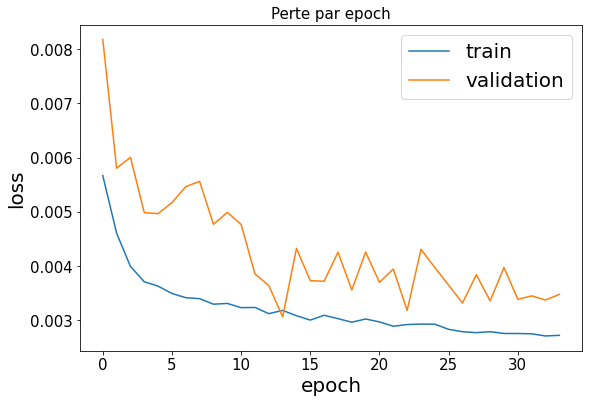

In [48]:
plt.figure(figsize=(9,6))
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Perte par epoch',fontsize=15)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'validation'], loc='best',fontsize=20)
plt.show();

Possibilité de sauvegarder le réseau obtenu. Nom au format *nom* \_ *date* \_ *clé aléatoire*.

In [49]:
import secrets
from datetime import datetime

name = "model"
date = datetime.today().strftime('%Y%m%d')
rand_key = secrets.token_hex(8)
full_name = f"{name}_{date}_{rand_key}"

unet.save(os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet",full_name))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projet Datascientest/UNet/model_20220122_8389ac2af3ba2c49/assets


## Chargement d'un réseau existant

In [ ]:
from tensorflow.keras.models import load_model

model_path = os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet","model_20220122")
unet = load_model(model_path)

#Modèles:
#model_20220122:fs=4 kHz - Model=2.3+LR+ES - Augment=2 - Batch=2 - 34 épochs - Loss=0.0027    Val_loss=0.0035     SDR=

# Evaluation du modèle

## Exemple de prédiction

True mix


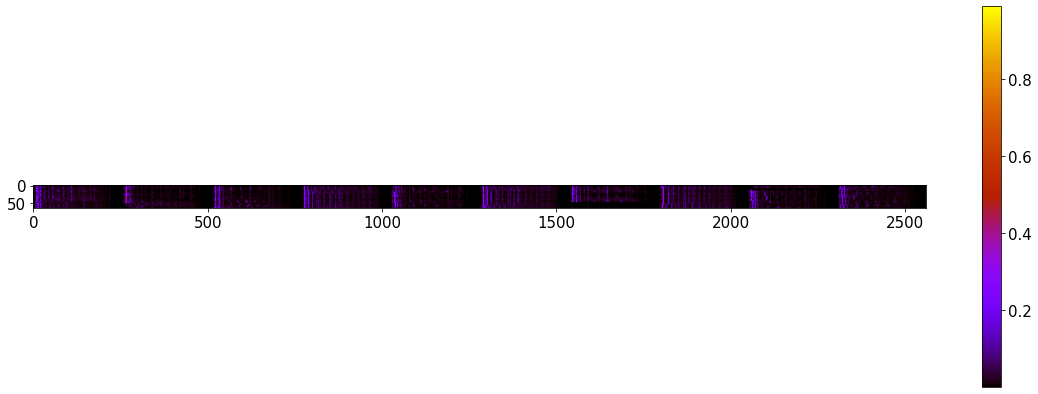

True voice


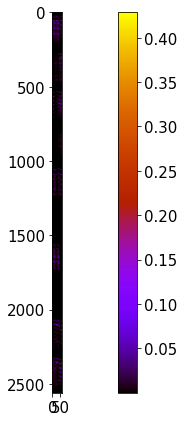

Predicted voice


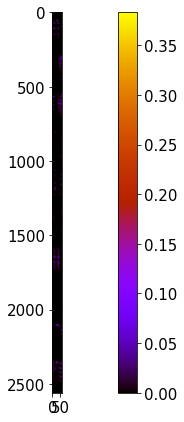

In [54]:
magmix, magvoice, *_ = preprocess(musdb_train[0])
X_mix, X_voice = reshape(magmix[:,:,0], magvoice[:,:,0], patch_size,dataaugment=False)

print("True mix")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_mix[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

print("True voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_voice[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0],cmap="gnuplot")
plt.colorbar()
plt.show()

ytest = unet.predict(X_mix[0:10,:,:,:].reshape(-1,nfreq,nframes,1))
print("Predicted voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([ytest[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0],cmap="gnuplot")
plt.colorbar()
plt.show()

## Visualisation complète et écoute d'une musique

(256, 2241, 1)
35 (256, 2240) 2240
(35, 256, 64, 1)
AudioSignal (unlabeled): 209.908 sec @ AM Contra - Heart Peripheral, 4096 Hz, 1 ch.


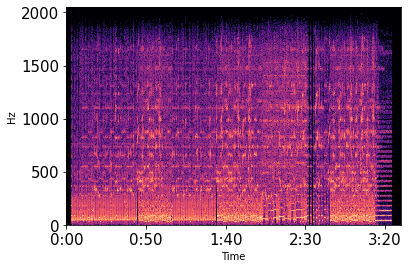

AudioSignal (unlabeled): 209.908 sec @ musdb/AM Contra - Heart Peripheral_vocals.wav, 4096 Hz, 1 ch.


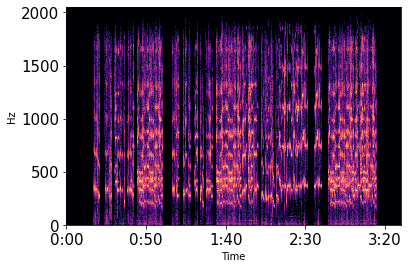

(35, 256, 64, 1)
mag (256, 2240, 1)
ph (256, 2241, 1)
AudioSignal (unlabeled): 209.906 sec @ path unknown, 4096 Hz, 1 ch.


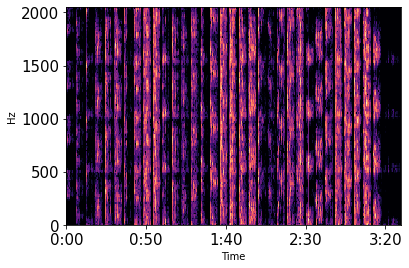

In [74]:
data = musdb_test[0]

magmix, magvoice, phase, norm = preprocess(data)
print(magmix.shape)
X_mix, X_voice = reshape(magmix[:,:,0], magvoice[:,:,0], patch_size, dataaugment=False)
print(X_mix.shape)

print(data["mix"])
data["mix"].embed_audio()
nussl.utils.visualize_spectrogram(data["mix"])
plt.show()

print(data["sources"]["vocals"])
data["sources"]["vocals"].embed_audio()
nussl.utils.visualize_spectrogram(data["sources"]["vocals"])
plt.show()

X_voice_pred =unet.predict(X_mix)
print(X_voice_pred.shape)
magmix_pred = X_voice_pred.reshape(-1,nfreq,1).transpose(1,0,2)
print('mag',magmix_pred.shape)
print('ph',phase.shape)
end0 = magmix_pred.shape[0]
end1 = magmix_pred.shape[1]
audio_pred = nussl.AudioSignal(stft=magmix_pred*norm*phase[:end0,:end1],sample_rate=freq)
audio_pred.istft(window_length=window_length,hop_length=hop_length)
print(audio_pred)
audio_pred.embed_audio()
nussl.utils.visualize_spectrogram(audio_pred)
plt.show()

